In [3846]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import random
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn

from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
from tqdm import tqdm
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B


In [4214]:
import pandas as pd
import os
os.chdir("C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/Functionnal Classifier")
# Lire le fichier CSV
sofa = pd.read_csv('sofa.csv')
T=20
# Attribuer des noms de colonnes personnalisés


# Afficher les noms de colonnes
print(sofa.columns)
grid_points=np.arange(T+1)[1:]
sofa.values.shape


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173',
       'V174'],
      dtype='object', length=174)


(520, 174)

In [4221]:
Y_X=torch.from_numpy(sofa.values).float().cuda()

y,x=Y_X[:,0].unsqueeze(1).unsqueeze(2).long(),Y_X[:,1:T+1].reshape(520,1,T)
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,shuffle=True)
x_train.shape,y_train.shape


(torch.Size([390, 1, 20]), torch.Size([390, 1, 1]))

In [3751]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.07)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.07)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [3269]:
##Hyper Paramètres:
basis=B(knots=linspace(1,T,6),order=3)
n_conv_out=1
granulation=2000
n_conv_in=128
n_conv_in2=128
n_conv_in3=64
n_Flat_out=128
stride_1=5
stride_2=2
stride_3=2
stride_pool_1=2
stride_pool_2=1
stride_pool_3=2
kernel_size_1=300
kernel_size_2=100
kernel_size_3=30
kernel_size_pool_1=8
kernel_size_pool_2=4
kernel_size_pool_3=2
dilation_1=1
dilation_2=1
dilation_3=1
dilation_pool_1=1
dilation_pool_2=1
dilation_pool_3=1
padding_1=2
padding_2=2
padding_3=2
padding_pool_1=1
padding_pool_2=1
padding_pool_3=1



In [3248]:

class Smooth_Strides_FCNN(nn.Module):
    def __init__(self,
basis=basis,
granulation=granulation,
n_conv_out=n_conv_out,
n_conv_in=n_conv_in,
n_conv_in2=n_conv_in2,
n_conv_in3=n_conv_in3,
n_Flat_out=n_Flat_out,
stride_1=stride_1,
stride_2=stride_2,
stride_3=stride_3,
stride_pool_1=stride_pool_1,
stride_pool_2=stride_pool_2,
stride_pool_3=stride_pool_3,
kernel_size_1=kernel_size_1,
kernel_size_2=kernel_size_2,
kernel_size_3=kernel_size_3,
kernel_size_pool_1=kernel_size_pool_1,
kernel_size_pool_2=kernel_size_pool_2,
kernel_size_pool_3=kernel_size_pool_3,
dilation_1=dilation_1,
dilation_2=dilation_2,
dilation_3=dilation_3,
dilation_pool_1=dilation_pool_1,
dilation_pool_2=dilation_pool_2,
dilation_pool_3=dilation_pool_3):
        super(Smooth_Strides_FCNN,self).__init__()

        self.Relu=nn.ReLU()

        self.convlayer1=nn.Sequential(
            nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
            nn.BatchNorm1d(n_conv_in),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer2=nn.Sequential(
            nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
            nn.BatchNorm1d(n_conv_in2),
            nn.LeakyReLU(0.18),
        )
        
        self.convlayer3=nn.Sequential(

            nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
            
            nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
            nn.BatchNorm1d(n_conv_in3),
            nn.LeakyReLU(0.18),
        )

        self.fc_block=nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
            nn.BatchNorm1d(n_Flat_out),
            nn.LeakyReLU(0.18),
            
            nn.Linear(n_Flat_out,2),
            
        )
        self.activation=nn.Softmax()
        self.n_conv_out=n_conv_out
    def Granulator(self,x):
        eval_points=linspace(1,T,granulation)
        basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
        basis_fc = torch.from_numpy(basis_eval).float().cuda()
        coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=basis).coefficients
        
        coefs_torch=torch.tensor(coefs).float().cuda()
        Recons_train=torch.matmul(coefs_torch,basis_fc)
        Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
        return Recons_train

    def forward(self,x):
        Granulated_x_train=self.Granulator(x)
        tresh_out=torch.relu(Granulated_x_train)
        Conv_out=self.convlayer1(tresh_out)
        Conv_out2=self.convlayer2(Conv_out)
        Conv_out3=self.convlayer3(Conv_out2)
        Lin_out=self.fc_block(Conv_out3)
        return Lin_out.float().unsqueeze_(2).unsqueeze_(3)


In [4352]:

def Compile_class(
        basis=basis,
        granulation=granulation,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3,
        padding_1=padding_1,
        padding_2=padding_2,
        padding_3=padding_3,
        padding_pool_1=padding_pool_1,
        padding_pool_2=padding_pool_2,
        padding_pool_3=padding_pool_3,
    ):
    CNN=Smooth_Strides_FCNN(
        n_conv_out=50,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3).cuda()
    Granul=CNN.Granulator(x_train[:1,:,:])
    Conv_out=CNN.convlayer1(Granul)
    Conv_out2=CNN.convlayer2(Conv_out)
    Conv_out3=CNN.convlayer3(Conv_out2)
    n_conv_out=Conv_out3.shape[2]
    class Bsp_classifier(nn.Module):
        def __init__(self,
        basis=basis,
        n_conv_out=n_conv_out,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3):
            super(Bsp_classifier,self).__init__()

            self.Relu=nn.ReLU()

            self.convlayer1=nn.Sequential(
                nn.Conv1d(1,n_conv_in,kernel_size=kernel_size_1,stride=stride_1,padding=padding_1,dilation=dilation_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
                
                nn.MaxPool1d(kernel_size=kernel_size_pool_1,stride=stride_pool_1,padding=padding_pool_1,dilation=dilation_pool_1),
                nn.BatchNorm1d(n_conv_in),
                nn.LeakyReLU(0.18),
            )
            
            self.convlayer2=nn.Sequential(
                nn.Conv1d(n_conv_in,n_conv_in2,kernel_size=kernel_size_2,stride=stride_2,padding=padding_2,dilation=dilation_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
                
                nn.MaxPool1d(kernel_size=kernel_size_pool_2,stride=stride_pool_2,padding=padding_pool_2,dilation=dilation_pool_2),
                nn.BatchNorm1d(n_conv_in2),
                nn.LeakyReLU(0.18),
            )
            
            self.convlayer3=nn.Sequential(

                nn.Conv1d(n_conv_in2,n_conv_in3,kernel_size=kernel_size_3,stride=stride_3,padding=padding_3,dilation=dilation_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
                
                nn.MaxPool1d(kernel_size=kernel_size_pool_3,stride=stride_pool_3,padding=padding_pool_3,dilation=dilation_pool_3),
                nn.BatchNorm1d(n_conv_in3),
                nn.LeakyReLU(0.18),
            )

            self.fc_block=nn.Sequential(
                nn.Flatten(),
                nn.Linear(n_conv_out*n_conv_in3,n_Flat_out),
                nn.BatchNorm1d(n_Flat_out),
                nn.LeakyReLU(0.18),
                
                nn.Linear(n_Flat_out,2),
                
            )
            self.basis=basis
            self.activation=nn.Softmax()
            self.n_conv_out=n_conv_out
        def Granulator(self,x):
            eval_points=linspace(1,T,granulation)
            basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
            basis_fc = torch.from_numpy(basis_eval).float().cuda()
            coefs=fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis=self.basis).coefficients
            
            coefs_torch=torch.tensor(coefs).float().cuda()
            Recons_train=torch.matmul(coefs_torch,basis_fc)
            Recons_train=Recons_train.reshape(Recons_train.shape[0],1,Recons_train.shape[1])
            return Recons_train

        def forward(self,x):
            Granulated_x_train=self.Granulator(x)
            tresh_out=torch.relu(Granulated_x_train)
            Conv_out=self.convlayer1(tresh_out)
            Conv_out2=self.convlayer2(Conv_out)
            Conv_out3=self.convlayer3(Conv_out2)
            Lin_out=self.fc_block(Conv_out3)
            return Lin_out.float().unsqueeze_(2).unsqueeze_(3)
    module=Bsp_classifier(
        n_conv_out=n_conv_out)
    return module

In [4226]:
def Compile_train(module=CNN, lr=lr_adam, opt="Adam", loss=loss_function, batch_size=batch_size):
    betas = [0.5, 0.999]
    if opt == "Adam":
        optimizer = optim.Adam(module.parameters(), lr=lr, betas=betas)
    else:
        optimizer = optim.SGD(module.parameters(), lr=lr)
    def train(n_epochs, module, optimizer, loss, batch_size):
        for epoch in range(n_epochs):
            train_loss = torch.tensor(0).cuda().long()
            
            # Mélanger les données d'entraînement
            indices = list(range(len(x_train)))
            random.shuffle(indices)
            
            batch_index = 0  # Indice de batch
            
            for i in range(int(len(x_train) / batch_size)):
                # Obtenir les indices des données mélangées
                batch_indices = indices[batch_index:batch_index+batch_size]
                
                functions_train = x_train[batch_indices,:,:]
                labels_train = y_train[batch_indices]
                
                optimizer.zero_grad()
                output = module(functions_train)
                loss_value = loss(input=output, target=labels_train)
                
                loss_value.backward()
                optimizer.step()
                train_loss += loss_value.long()
                
                batch_index += batch_size  # Passer au prochain batch
                
            return train_loss, loss_value
    
    return lambda n_epochs: train(n_epochs, module, optimizer, loss, batch_size)


In [4373]:
def Hyperparameter_Search(
        n_epochs=50,
        basis=basis,
        granulation=granulation,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3,
        padding_1=padding_1,
        padding_2=padding_2,
        padding_3=padding_3,
        padding_pool_1=padding_pool_1,
        padding_pool_2=padding_pool_2,
        padding_pool_3=padding_pool_3,
        lr=lr_adam,
        batch_size=batch_size,
        opt="Adam",
        loss=nn.CrossEntropyLoss(), 
        ):

    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,shuffle=True)    
    ##Compilation de la classe 
    Model=Compile_class(
        basis=basis,
        granulation=granulation,
        n_conv_in=n_conv_in,
        n_conv_in2=n_conv_in2,
        n_conv_in3=n_conv_in3,
        n_Flat_out=n_Flat_out,
        stride_1=stride_1,
        stride_2=stride_2,
        stride_3=stride_3,
        stride_pool_1=stride_pool_1,
        stride_pool_2=stride_pool_2,
        stride_pool_3=stride_pool_3,
        kernel_size_1=kernel_size_1,
        kernel_size_2=kernel_size_2,
        kernel_size_3=kernel_size_3,
        kernel_size_pool_1=kernel_size_pool_1,
        kernel_size_pool_2=kernel_size_pool_2,
        kernel_size_pool_3=kernel_size_pool_3,
        dilation_1=dilation_1,
        dilation_2=dilation_2,
        dilation_3=dilation_3,
        dilation_pool_1=dilation_pool_1,
        dilation_pool_2=dilation_pool_2,
        dilation_pool_3=dilation_pool_3,
        padding_1=padding_1,
        padding_2=padding_2,
        padding_3=padding_3,
        padding_pool_1=padding_pool_1,
        padding_pool_2=padding_pool_2,
        padding_pool_3=padding_pool_3,
    ).cuda().apply(weights_init_normal)
    
    
    mean_accuracy=torch.tensor([0])
    train_fn = Compile_train(module=Model, lr=lr_adam, opt="Adam", loss=loss_function, batch_size=batch_size)
    train_fn(n_epochs=1)
    for i in tqdm(range(n_epochs)):
            train_fn(n_epochs=1)
            
            accuracy=((torch.sum(torch.argmax(Model(x_test),dim=1)==y_test)/x_test.shape[0])*100)
            mean_accuracy=torch.cat([mean_accuracy,accuracy.cpu().unsqueeze(0)],dim=0)
    print("Précision moyenne =",((torch.mean(mean_accuracy[1:].float()))).detach().cpu().numpy(),"%")  
    print("Précision max=",((torch.max(mean_accuracy[1:].float()))).detach().cpu().numpy(),"%")  
    print("Variance des précisions =",((torch.var(mean_accuracy[1:].float()))).detach().cpu().numpy())  
    print(mean_accuracy.unsqueeze(1)[1:]) 
    
   # convlayer: Elles sont smooth!! (en apparence du moins)
#ATTENTION, LES CONVLAYER NE SONT PAS FORCEMENT SMOOTH
    
    
    grid_test=fd(x_test[:,0,:].cpu(),grid_points=grid_points).to_basis(basis)
    grid_convlayer1=fd(Model.convlayer1(Model.Granulator(x_test))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer1(Model.Granulator(x_test)).shape[2]))
    grid_convlayer2=fd(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test)))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer2(Model.convlayer1(Model.Granulator(x_test))).shape[2]))
    grid_convlayer3=fd(Model.convlayer3(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test))))[:,0,:].detach().cpu(),grid_points=linspace(1,T,Model.convlayer3(Model.convlayer2(Model.convlayer1(Model.Granulator(x_test)))).shape[2]))
        
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    return Model,grid_convlayer1,grid_convlayer2,grid_convlayer3, mean_accuracy[1:]



In [4371]:
FCNN,grid_convlayer1,grid_convlayer2,grid_convlayer3, Acc=Hyperparameter_Search(
    n_epochs=25,    
    basis=B(knots=linspace(1,T,6),order=3),
    granulation=2000,
    n_conv_in=128,
    n_conv_in2=128,
    n_conv_in3=64,
    n_Flat_out=256,
    stride_1=6,
    stride_2=2,
    stride_3=1,
    stride_pool_1=2,
    stride_pool_2=2,
    stride_pool_3=1,
    kernel_size_1=200,
    kernel_size_2=50,
    kernel_size_3=20,
    kernel_size_pool_1=6,
    kernel_size_pool_2=4,
    kernel_size_pool_3=2,
    dilation_1=1,
    dilation_2=1,
    dilation_3=1,
    dilation_pool_1=1,
    dilation_pool_2=1,
    dilation_pool_3=1,
    padding_1=2,
    padding_2=2,
    padding_3=2,
    padding_pool_1=1,
    padding_pool_2=1,
    padding_pool_3=1,
    opt="Adam",
    lr=0.00089,
    loss=nn.CrossEntropyLoss()
)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9256\1814234103.py:76: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_9256\998809527.py:137: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  basis_eval=basis.evaluate(eval_points=eval_points)[:, :, 0]
100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Précision moyenne = 90.46153 %
Précision max= 93.07692 %
Variance des précisions = 4.1420155
tensor([[83.8462],
        [86.9231],
        [88.4615],
        [88.4615],
        [89.2308],
        [89.2308],
        [90.7692],
        [90.7692],
        [91.5385],
        [90.0000],
        [91.5385],
        [90.7692],
        [88.4615],
        [91.5385],
        [91.5385],
        [91.5385],
        [91.5385],
        [91.5385],
        [91.5385],
        [92.3077],
        [91.5385],
        [92.3077],
        [90.7692],
        [93.0769],
        [92.3077]])


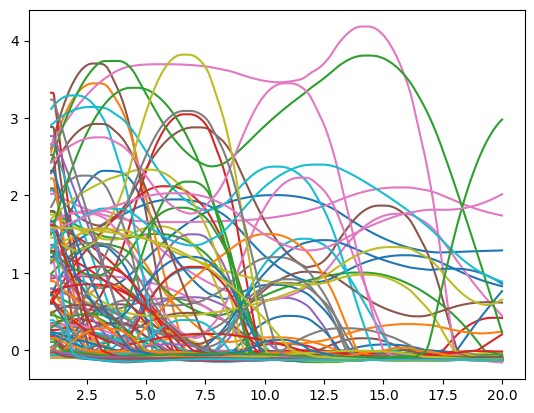

In [4344]:

grid_convlayer1.plot()
plt.show()

In [4372]:
import gc
torch.cuda.empty_cache()
gc.collect()

21